# Project 2 - Classification
Welcome to the second project in Data 8!  You will build a classifier that guesses whether a song is hip-hop or country, using only the numbers of times words appear in the song's lyrics.  By the end of the project, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.
3. Evaluate different sets of features.

**Run the cell below** to prepare the automatic tests. **Passing the automatic tests does not guarantee full credit on any question.** The tests are provided to help catch some common errors, but it is your responsibility to answer the questions correctly.

In [1]:
# Run this cell, but please don't change it.

import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# These lines load the tests.
from client.api.assignment import load_assignment 
project2 = load_assignment('project2.ok')

Assignment: Project 2
OK, version v1.6.4



# 1. The Dataset

Our dataset is a table of songs, each with a name, an artist, and a genre.  For each song, we also know how frequently certain words occur in that song.  More precisely, we have a list of approximately 5000 words.  For each of these words, for each song, each item in the table describes the proportion of the song's lyrics that are the particular word.

For example, the lyrics of "In Your Eyes" is 168 words long. The word "like" appears twice:  $\frac{2}{168} \approx 0.0119$ of the words in the song. Similarly, the word "love" appears 10 times: $\frac{10}{168} \approx 0.0595$ of the words. Therefore, `lyrics.where("Title", "In Your Eyes").column("like").item(0)` is about $0.0119$, and `lyrics.where("Title", "In Your Eyes").column("love").item(0)` is about $0.0595$.

Our dataset doesn't contain all information about a song.  For example, it doesn't include the total number of words in each song, or information about the order of words in the song, let alone the melody, instruments, or rhythm. Nonetheless, you may find that word counts alone are sufficient to build an accurate genre classifier.

Run the cell below to read the `lyrics` table. **It may take up to a minute to load.**

In [2]:
# Just run this cell.
lyrics = Table.read_table('data/lyrics_clean.csv')

# The first 5 rows and 8 columns of the table
lyrics.select(np.arange(8)).show(5)

Title,Artist,Genre,i,the,you,to,and
Slicker Than Your Average,Craig David,Hip-hop,0.0495356,0.0170279,0.0356037,0.0201238,0.00773994
Right There,MF Grimm,Hip-hop,0.0378251,0.0543735,0.0236407,0.0496454,0.00945627
Talkin' All That,Cashis,Hip-hop,0.0567376,0.0496454,0.0514184,0.0106383,0.0265957
It Only Hurts Me When I Cry,Raul Malo,Country,0.0964912,0.0745614,0.0307017,0.0175439,0.0263158
Is It Too Late Now,Lester Flatt & Earl Scruggs,Country,0.0439024,0,0.0731707,0.0195122,0


All titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

In [3]:
title_index = lyrics.index_by('Title')
def row_for_title(title):
    return title_index.get(title)[0]

**Question 1.1:** Set `expected_row_sum` to the number that you expect will result from summing all proportions in each row, excluding the first three columns. 

In [4]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

In [5]:
_ = project2.grade('q11')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Sanity check (optional & ungraded):** To check that the actual row sums are close to what you expect, draw the histogram below.

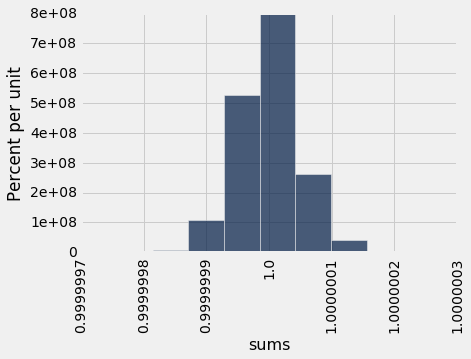

In [6]:
# Run this cell to display a histogram of the sums of proportions in each row.
# This computation might take up to a minute; you can skip it if it's too slow.
Table().with_column('sums', lyrics.drop([0, 1, 2]).apply(sum)).hist(0)

This dataset was extracted from the Million Song Dataset (http://labrosa.ee.columbia.edu/millionsong/). Specifically, we are using the complementary datasets from musiXmatch (http://labrosa.ee.columbia.edu/millionsong/musixmatch) and Last.fm (http://labrosa.ee.columbia.edu/millionsong/lastfm).

The counts of common words in the lyrics for all of these songs are provided by the musiXmatch dataset (called a bag-of-words format). Only the top 5000 most common words are represented. For each song, we divided the number of occurrences of each word by the total number of word occurrences in the lyrics of that song.

The Last.fm dataset contains multiple tags for each song in the Million Song Dataset. Some of the tags are genre-related, such as "pop", "rock", "classic", etc.  To obtain our dataset, we first extracted songs with Last.fm tags that included the words "country", or "hip" and "hop". These songs were then cross-referenced with the musiXmatch dataset, and only songs with musixMatch lyrics were placed into our dataset. Finally, inappropriate words and songs with naughty titles were removed, leaving us with 4976 words in the vocabulary and 1726 songs.

## 1.1. Word Stemming
The columns other than Title, Artist, and Genre in the `lyrics` table are all words that appear in some of the songs in our dataset.  Some of those names have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each song.  

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [7]:
# Just run this cell.
vocab_mapping = Table.read_table('data/mxm_reverse_mapping_safe.csv')
stemmed = np.take(lyrics.labels, np.arange(3, len(lyrics.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(range(900, 910))

Stem,Word
coup,coup
coupl,couple
courag,courage
cours,course
court,court
cousin,cousin
cover,cover
cow,cow
coward,coward
cowboy,cowboy


**Question 1.1.1:** Assign `unchanged` to the **percentage** of words in `vocab_table` that are the same as their stemmed form (such as "coup" above). 

In [8]:
unchanged = (np.count_nonzero(vocab_table.column(0) == vocab_table.column(1))\
             / vocab_table.num_rows) * 100
print(str(round(unchanged)) + '%')

72%


**Question 1.1.2:** Assign `stemmed_message` to the stemmed version of the word "message".

In [9]:
# Set stemmed_message to the stemmed version of "message" (which
# should be a string).  Use vocab_table.
stemmed_message = vocab_table.where('Word', 'message').column(0).item(0)
stemmed_message

'messag'

In [10]:
_ = project2.grade("q112")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.1.3:** Assign `unstemmed_singl` to the word in `vocab_table` that has "singl" as its stemmed form. (*Note that multiple English words may stem to "singl", but only one example appears in `vocab_table`.*)

In [11]:
# Set unstemmed_singl to the unstemmed version of "single" (which
# should be a string).
unstemmed_singl = vocab_table.where('Stem', 'singl').column(1).item(0)
unstemmed_singl

'single'

In [12]:
_ = project2.grade("q113")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.1.4:** What word in `vocab_table` was shortened the most by this stemming process? Assign `most_shortened` to the word. It's an example of how heuristic stemming can collapse two unrelated words into the same stem (which is bad, but happens a lot in practice anyway).

In [13]:
# In our solution, we found it useful to first make an array
# called shortened containing the number of characters that was
# chopped off of each word in vocab_table, but you don't have
# to do that.
shortened = vocab_table.apply(len, 1) - vocab_table.apply(len, 0)
most_shortened = vocab_table.where(shortened == max(shortened)).column(1).item(0)
vocab_table.where('Word', most_shortened)

Stem,Word
intern,international


In [14]:
_ = project2.grade("q114")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 1.2. Splitting the dataset
We're going to use our `lyrics` dataset for three purposes.  First, we want to *train* various song genre classifiers.  Second, we want to *validate* which classifier is most effective. Finally, we want to *test* the performance of our final classifier. Hence, we need three different datasets: *training*, *validation*, and *test*.

The purpose of a classifier is to generalize to unseen data that is similar to the training data. Therefore, we must ensure that there are no songs that appear in two different sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training, the next part for validation, and the last for test. 

Run the code below (without changing it) to separate the three datasets into tables.

In [15]:
# Here we have defined the proportion of our data
# that we want to designate for training as 11/16ths
# of our total dataset.  2/16ths of the data is
# reserved for validation.  The remaining 3/16ths
# will be used for testing.

training_proportion = 11/16
validation_proportion = 2/16
num_songs = lyrics.num_rows

num_train = int(num_songs * training_proportion)
num_valid = int(num_songs * validation_proportion)
num_test = num_songs - num_train - num_valid

train_lyrics = lyrics.take(range(num_train))
valid_lyrics = lyrics.take(range(num_train, num_train + num_valid))
test_lyrics = lyrics.take(range(num_train + num_valid, num_songs))

print("Training: ",   train_lyrics.num_rows, ";",
      "Validation: ", valid_lyrics.num_rows, ";",
      "Test: ",       test_lyrics.num_rows)

Training:  1183 ; Validation:  215 ; Test:  323


**Question 1.2.1.** Draw a horizontal bar chart with three bars that shows the proportion of Country songs in each of the three datasets.

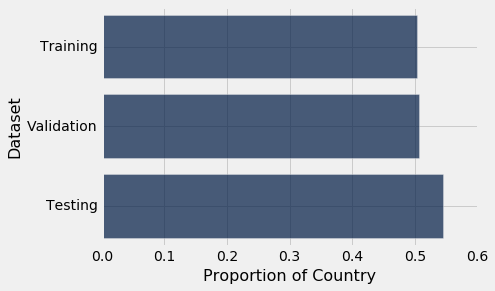

In [16]:
def country_proportion(table):
    """Return the proportion of songs in a table that have the Country genre."""
    return table.where('Genre', 'Country').num_rows / table.num_rows

Table(['Dataset', 'Proportion of Country']).with_rows([
        ['Training', country_proportion(train_lyrics)],
        ['Validation', country_proportion(valid_lyrics)],
        ['Testing', country_proportion(test_lyrics)]
        ]).barh('Dataset')

# 2. K-Nearest Neighbors - a Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some *features* of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples.  

A feature we have about each song is *the proportion of times a particular word appears in the lyrics*, and the categories are two music genres: hip-hop and country.  The algorithm requires many previously seen examples for which both the features and categories are known: that's the `train_lyrics` table.

We're going to visualize the algorithm, instead of just describing it. To get started, let's pick colors for the genres.

In [17]:
# Just run this cell to define genre_color.

def genre_color(genre):
    """Assign a color to each genre."""
    if genre == 'Country':
        return 'gold'
    elif genre == 'Hip-hop':
        return 'blue'
    else:
        return 'green'

## 2.1. Classifying a  song

In k-NN, we classify a song by finding the `k` songs in the *training set* that are most similar according to the features we choose. We call those songs with similar features the "neighbors".  The k-NN algorithm assigns the song to the most common category among its `k` neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each song.  The features we will use are the proportions of the words "like" and "love" in the lyrics.  Taking the song "In Your Eyes" (in the test set), 0.0119 of its words are "like" and 0.0595 are "love". This song appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *dissimilarity*, or *distance* between two songs is the straight-line distance between them when we plot their features in a scatter diagram. This distance is called the Euclidean ("yoo-KLID-ee-un") distance.  

For example, in the song *Insane in the Brain* (in the training set), 0.0203 of all the words in the song are "like" and 0 are "love".  Its distance from *In Your Eyes* on this 2-word feature set is $\sqrt{(0.0119 - 0.0203)^2 + (0.0595 - 0)^2} \approx 0.06$.  (If we included more or different features, the distance could be different.)

A third song, *Sangria Wine* (in the training set), is 0.0044 "like" and 0.0925 "love".

The function below creates a plot to display a test song and some training songs in a two-dimensional space defined by two features. As you can see in the result, *In Your Eyes* is more similar to *Sangria Wine* than to *Insane in the Brain*.

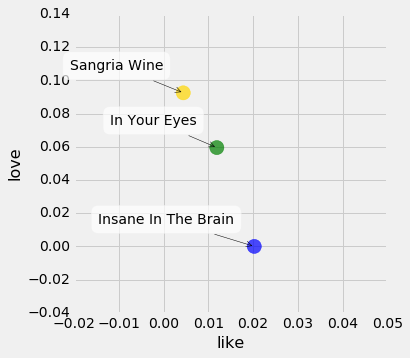

In [18]:
# Just run this cell.

def plot_with_two_features(test_song, training_songs, x_feature, y_feature):
    """Plot a test song and training songs using two features."""
    test_row = row_for_title(test_song)
    distances = Table().with_columns([
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   [genre_color('Unknown')],
            'Title',   [test_song]
        ])
    for song in training_songs:
        row = row_for_title(song)
        color = genre_color(row.item('Genre'))
        distances.append([row.item(x_feature), row.item(y_feature), color, song])
    distances.scatter(x_feature, y_feature, colors='Color', labels='Title', s=200)
    
training = ["Sangria Wine", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

**Question 2.1.1.** Compute the Euclidean distance between the two country songs, *In Your Eyes* and *Sangria Wine* on the `['like', 'love']` feature set, and assign it to `country_distance`. 

In [19]:
in_your_eyes = row_for_title("In Your Eyes")
sangria_wine = row_for_title("Sangria Wine")
country_distance = ((in_your_eyes.item('like') - sangria_wine.item('like')) ** 2
                    + (in_your_eyes.item('love') - sangria_wine.item('love')) ** 2) ** 0.5
country_distance

0.033828944324596891

In [20]:
_ = project2.grade("q211")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



The `plot_with_two_features` function can show the positions of several training songs. Below, we've added one that's even closer to *In Your Eyes*.

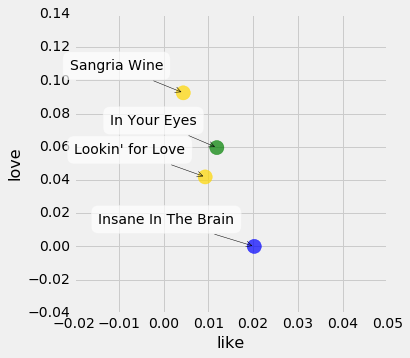

In [21]:
training = ["Sangria Wine", "Lookin' for Love", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

**Question 2.1.2.** Complete the function `distance_two_features` that computes the Euclidean distance between any two songs, using two features. The last two lines call the `distance_two_features` function  to show that *Lookin' for Love* is closer to *In Your Eyes* than *Insane In The Brain*. 

In [22]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two songs, represented as rows."""
    row0 = row_for_title(title0)
    row1 = row_for_title(title1)
    return ((row0.item(x_feature) - row1.item(x_feature)) ** 2
                + (row0.item(y_feature) - row1.item(y_feature)) ** 2) ** 0.5

for song in ["Lookin' for Love", "Insane In The Brain"]:
    song_distance = distance_two_features(song, "In Your Eyes", "like", "love")
    print(song, 'distance:\t', song_distance)

Lookin' for Love distance:	 0.0178540259516
Insane In The Brain distance:	 0.0601087823407


In [23]:
_ = project2.grade("q212")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



The nearest neighbor to a song is the example in the training set that has the smallest distance from that song.

**Question 2.1.3.** Define the higher-order function `distance_from` that takes a single song title and two features. It returns a function `for_song` that takes a second song title and computes the distance between the first and second songs.

*Hint: Call `distance_two_features` in your solution rather than re-implementing its computation.*

In [24]:
def distance_from(title0, x_feature, y_feature):
    def for_song(title1):
        return distance_two_features(title0, title1, x_feature, y_feature)
    return for_song

distance_from_in_your_eyes = distance_from("In Your Eyes", "like", "love")
distance_from_in_your_eyes("Lookin' for Love")

0.017854025951587398

In [25]:
_ = project2.grade("q213")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2.1.4.**  What are the names and genres of the 7 closest songs to "In Your Eyes" in  `train_lyrics`, by Euclidean distance for the 2 features "like" and "love"?  To answer this question, make a table named `close_songs` containing those 7 songs with columns "Title", "Artist", "Genre", "like", and "love" from the `lyrics` table, as well as a column called `distance` that contains the distance from "In Your Eyes" **sorted in ascending order**.

In [26]:
like_love = train_lyrics.select(["Title", "Artist", "Genre", "like", "love"])
close_songs = like_love.with_column('distance', like_love\
                                    .apply(distance_from_in_your_eyes, 0))\
                                    .sort(5).take(range(7))
close_songs

Title,Artist,Genre,like,love,distance
If This Isn't Love,Jennifer Hudson,Hip-hop,0.00886918,0.0532151,0.00700106
Big Red Rocket Of Love,Reverend Horton Heat,Hip-hop,0,0.0576923,0.0120448
In the Middle of a Heartache,Wanda Jackson,Country,0,0.0639535,0.0127022
The Hardest Part,Allison Moorer,Country,0,0.0642857,0.0128218
One Time,Justin Bieber,Hip-hop,0,0.0530303,0.0135606
This Tornado Loves You,Neko Case,Country,0,0.0528455,0.01365
You Can Have Her,Jim Ed Brown & The Browns,Country,0,0.0521327,0.0140126


In [27]:
_ = project2.grade("q214")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2.1.5 .** Write a function `most_common` that takes a `column_label` and a `table`. It returns the most common value in that column of that table. In case of a tie, it can return any of the most common values.

In [28]:
def most_common(column_label, table):
    return table.group(column_label).sort(1).row(-1).item('Genre')

# Calling most_common classifies In Your Eyes as a country song, 4 votes to 3.
most_common('Genre', close_songs)

'Country'

In [29]:
_ = project2.grade("q215")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Congratulations are in order -- you've classified your first song!

# 3. Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two songs, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

**Question 3.1.** Write a function to compute the Euclidean distance between two *arrays* of features of *arbitrary* (but equal) length.  Use it to compute the distance between the first song in the training set and the first song in the test set, *using all of the features*.  (Remember that the title, artist, and genre of the songs are not features.)

In [30]:
def distance(features1, features2):
    """The Euclidian distance between two arrays of feature values."""        
    return sum(((features1 - features2) ** 2)) ** 0.5

distance_first_to_first = distance(np.array(train_lyrics.drop(range(3)).row(0)),
                                   np.array(test_lyrics.drop(range(3)).row(0)))
distance_first_to_first

0.21646718922539046

In [31]:
_ = project2.grade("q31")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  We'll explore that more later, but one clear downside is *computational* -- computing Euclidean distances just takes a long time when we have lots of features.  So we're going to select just 20 for now.  We'd like to choose features that are very *discriminative*, that is, which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or more broadly *feature engineering*.

**Question 3.1.1.** Look through the list of features (the labels of the `lyrics` table after the first three).  Choose 20 that you think will let you distinguish pretty well between country and hip-hop songs.  You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier.  The first time you do this question, spend some time looking through the features, but not more than 15 minutes.

In [32]:
# Set my_20_features to a list of 20 features (strings that are column labels)
my_20_features = ['god', 'soul', 'friend', 'gonna', 'heart', 'yeah', 'kill', 'doe', 'heaven',
                  'understand','em', 'das', 'angel', 'oh', 'ba', 'love', 'ladi', 'troubl',
                  'goin', 'uh']
train_20 = train_lyrics.select(my_20_features)
test_20 = test_lyrics.select(my_20_features)

In [33]:
_ = project2.grade("q311")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.1.2** In a few sentences, describe how you selected your features. 

I scanned through the `lyrics` table and selected words that I found most often in country songs and hip-hop songs, but not generally in both. For example, `das`, `ladi` and `ja` I found to be more in hip-hop songs whereas `god`, `soul` and `heaven` I found to be in more country songs.

Next, let's classify the first song from our test set using these features.  You can examine the song by running the cells below. Do you think it will be classified correctly?

In [34]:
test_lyrics.take(0).select(['Title', 'Artist', 'Genre'])

Title,Artist,Genre
Just To Satisfy You,Waylon Jennings & Willie Nelson,Country


In [35]:
test_20.take(0)

god,soul,friend,gonna,heart,yeah,kill,doe,heaven,understand,em,das,angel,oh,ba,love,ladi,troubl,goin,uh
0,0,0,0.0555556,0.0246914,0,0,0,0,0,0,0,0,0,0,0.0123457,0,0,0,0


As before, we want to look for the songs in the training set that are most alike our test song.  We will calculate the Euclidean distances from the test song (using the 20 selected features) to all songs in the training set.  You could do this with `apply` or a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.

In [36]:
# Just run this cell to define fast_distances.

# Takes 2 arguments: a table with a single row containing
# features of one test song (e.g., test_20.row(0)),
# and another table of features (for example, the whole
# table train_20).  Returns an array of distances,
# where the ith element is the distance from test_row to
# the ith row in counts_table.  
#
# This function is equivalent to using apply, but faster.
# It uses several techniques not covered in the course.
def fast_distances(test_row, train_rows):
    counts_matrix = np.asmatrix(train_rows.columns).transpose()
    diff = np.tile(np.array(test_row), [counts_matrix.shape[0], 1]) - counts_matrix
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    return distances

**Question 3.1.3.** Use the `fast_distances` function provided above to compute the distance of the first song in the test set to all the songs in the training set.  Make a new table called `genre_and_distances` with one row for each song in the training set and two columns:
* The `"Genre"` of the training song
* The `"Distance"` from the first song in the test set 

Ensure that `genre_and_distances` is **sorted by increasing distance to the first test song**.

In [37]:
distances = fast_distances(test_20.row(0), train_20)

genre_and_distances = Table().with_columns([
        ['Genre', train_lyrics.column('Genre')],
        ['Distance', distances]
        ]).sort(1)
genre_and_distances

Genre,Distance
Country,0.0218376
Country,0.0220847
Country,0.0241007
Country,0.0271096
Country,0.0279866
Country,0.0291262
Hip-hop,0.0299537
Hip-hop,0.031661
Hip-hop,0.0316713
Hip-hop,0.0325375


In [38]:
_ = project2.grade("q313")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.1.4.**  Now compute the 5-nearest neighbors classification of the first song in the test set.  That is, decide on its genre by finding the most common genre among its 5 nearest neighbors, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this song right, and that's okay.)

In [39]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = most_common('Genre', genre_and_distances.take(range(5)))

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first song in the test set.
my_assigned_genre_was_correct = True

print("The assigned genre", my_assigned_genre, "was correct...", my_assigned_genre_was_correct )

The assigned genre Country was correct... True


In [40]:
_ = project2.grade("q314")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 3.2. A classifier function

Now it's time to write a single function that encapsulates this whole process of classification.

**Question 3.2.1.** Write a function called `classify`.  It should take the following arguments:
* An array of features for a song to classify (e.g., `test_20.row(0)`),
* A table with a column for each feature (for example, `train_20`)
* An array of classes that has as many items as the previous table has rows, and in the same order, and
* `k`, the number of neighbors to use in classification.

It should return the class your classifier picks for the given row of features (e.g., `'Country'` or `'Hip-hop'`). 

In [41]:
def classify(test_row, train_rows, train_classes, k):
    """Return the most common class among k nearest neighbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    genre_and_distance = Table().with_columns([
        ['Genre', train_classes],
        ['Distance', distances]
        ]).sort(1)
    return most_common('Genre', genre_and_distance.take(range(k)))

In [42]:
_ = project2.grade("q321")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.2.2.** Assign `grandpa_genre` to the genre predicted by your classifier for the song  "Grandpa Got Runned Over By A John Deere" in the test set, using 9 neigbors.

In [43]:
grandpa_features = test_lyrics.where('Title', 'Grandpa Got Runned Over By A John Deere').select(my_20_features).row(0)
grandpa_genre = classify(grandpa_features, test_20, test_lyrics.column('Genre'), 9)
grandpa_genre

'Hip-hop'

In [44]:
_ = project2.grade("q322")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.2.3** To simplify things further, use the higher-order function `classify_using` that takes `train_rows`, `train_classes`, and `k` to define a function `simple_classify`. The `simple_classify` function should take just one argument, a test row, and return the predicted genre of a song using `train_20` and five neighbors (`k` of 5).  This way, when we classify a song, we just have to pass in the song's features, not the whole training set.  

In [45]:
def classify_using(train_rows, train_classes, k):
    def for_row(test_row):
        return classify(test_row, train_rows, train_classes, k)
    return for_row

simple_classify = classify_using(train_20, train_lyrics.column('Genre'), 5)
simple_classify(test_20.row(0))

'Country'

In [46]:
_ = project2.grade("q323")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 3.3. Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1.** Classify every song in the test set (provided), then compute the proportion of correct classifications. 

In [47]:
test_guesses = test_20.apply(simple_classify)
proportion_correct = np.count_nonzero(test_guesses == test_lyrics.column('Genre')) / test_lyrics.num_rows
proportion_correct

0.653250773993808

In [48]:
_ = project2.grade("q331")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

In practice, if the performance is good enough for your application, you might be done. In this case, we might be able to do better by focusing on step 3.

# 4. Feature design

One way to interpret the accuracy of a classifier is to compare it to another classifier.

**Question 4.1.** Below we've provided 10 features selected by the staff.  Build a 5-nearest-neighbor classifier using these features and compute its accuracy on the test set. (You can write any code you want, as long as `proportion_correct_staff` is computed correctly; the other names are only suggestions.)

In [49]:
staff_training_proportion = 10/16
staff_train_num = int(num_songs * staff_training_proportion)

features_staff = ["come", "do", "have", "heart", "make", "never", "now", "wanna", "with", "yo"]
train_staff = lyrics.take(range(staff_train_num))
test_staff = lyrics.take(range(staff_train_num, num_songs))                         
classify_staff = classify_using(train_staff.select(features_staff), train_staff.column('Genre'), 5)
guesses_staff = test_staff.select(features_staff).apply(classify_staff)
proportion_correct_staff = np.count_nonzero(guesses_staff == test_staff.column('Genre')) / test_staff.num_rows
proportion_correct_staff

0.7492260061919505

In [50]:
_ = project2.grade("q41")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Question 4.1 > Suite 1 > Case 1

>>> np.isclose(proportion_correct_staff, 0.7058823529411765)
False

# Error: expected and actual results do not match

---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



**Question 4.2.** Are the features you chose better or worse than the staff features at classifying the test set? Why do you think this is so?

The features we chose were worse than the staff features. Based on testing different proportions for training and testing, this seems to hold true for many (if not all) proportions. This is likely because the features picked by the staff likely show up more exclusively in one genre of music than another as compared to the features we picked, which may show up more occasionally in both genres.

**Question 4.3.** Is there anything random about a classifier's accuracy measured in this way?  Is it possible that the difference in classifier performance is due to chance?  If so, describe (in 2-3 sentences) how you would investigate that.

**No, in the current implementation, there does not exist an element of randomness.** The proportions and features we pre-decided may at best be arbitrary, but they are not random. If we re-run the experiement with the fixed variables, we will encounter the same results.

**Yes, classifier performance *CAN* be affected by chance.** If we were to introduce an element of randomness, it could be possible that sampling rows at random (instead of the first X or so via proportions) could affect the performance of the staff classifier and our classifier. We would need to re-run a series of experiments and determine the average performance.

## 4.1. Feature selection

What happens if we use only use a subset of the staff features? Is there a single feature that's better than the rest? Can removing features improve our classifier? Does removing features always hurt? If so, does removing different features degrade accuracy by different amounts?

As soon as you begin comparing the performance of many different classifiers, searching for the best one, it is important to conduct that search on the *validation set* rather than the *test set*. Conventionally, the test set is used for evaluation of methods. The validation set is used to select exactly how a method is applied, such as choosing a set of features or a value for `k`.  The validation set is called `valid_lyrics`.

**Question 4.1.1.** Define a higher-order function `accuracy_on` that takes an evaluation set, either `valid_lyrics` or `test_lyrics`. It returns a function that takes a feature list and a value for `k`, and returns the accuracy (proprotion correct) of a `k`-NN classifier on the evaluation set using those features.

In [51]:
def accuracy_on(evaluation_set):
    def accuracy(features, k):
        train = train_lyrics.select(features)
        validation = evaluation_set.select(features)
        classifier = classify_using(train, train_lyrics.column('Genre'), k)
        guesses = evaluation_set.select(features).apply(classifier)
        return np.count_nonzero(guesses == evaluation_set.column('Genre')) / evaluation_set.num_rows
    return accuracy

valid_accuracy = accuracy_on(valid_lyrics)
valid_accuracy(features_staff, 5)

0.7953488372093023

In [52]:
_ = project2.grade("q411")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 4.1.2.** Create a two-column table `solo_accuracies` that shows the accuracy on the validation set using 5 neighbors and only a single feature. Include a row for every feature in `staff_features`.

In [53]:
solo_accuracies = Table(['Feature', 'Solo Accuracy'])
for f in features_staff:
    solo_accuracies.append([f, valid_accuracy(f, 5)])
solo_accuracies.sort(1, descending=True)

Feature,Solo Accuracy
yo,0.674419
make,0.674419
wanna,0.660465
now,0.632558
heart,0.627907
never,0.623256
with,0.618605
have,0.590698
do,0.586047
come,0.55814


In [54]:
_ = project2.grade("q412")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



An *ablation* study involves attempting to determine which features matter most for classification accuracy by removing ("ablating") each of them individually.

**Question 4.1.3.** Create a two-column table `ablation_accuracies` that shows the accuracy on the validation set of a 5-NN classifier that has all `staff_features` except one. Include a row for every feature in `staff_features` that you leave out. (*Hint*: Lists have a `.remove` method that takes the element to be removed.)

In [55]:
ablation_accuracies = Table(['Feature', 'All-Except-One Accuracy'])
for f in features_staff:
    features = list(features_staff) # Make a copy of the staff features
    features.remove(f)              # Remove one feature from the copy
    ablation_accuracies.append([f, valid_accuracy(features, 5)])
ablation_accuracies.sort(1)

Feature,All-Except-One Accuracy
with,0.734884
yo,0.739535
have,0.744186
do,0.75814
heart,0.75814
never,0.776744
now,0.776744
come,0.781395
wanna,0.790698
make,0.795349


In [56]:
_ = project2.grade("q413")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 4.1.4.** You should have found that both "make" and "yo" have a high solo accuracy, but they have very different effects on the classifier when removed. Which feature appears to be more important to the final classifier?

**make** seems to be a more important classifier, as the classifier's accuracy grows by `0.069` when the word is feature is removed from the list

**Question 4.1.5.** Draw a scatter diagram with one dot for every **odd** value of `k` from 1 to 15 (inclusive) that plots the accuracy on the validation set on the horizontal axis and accuracy on the test set on the vertical axis. Use `features_staff` as the features for all points.

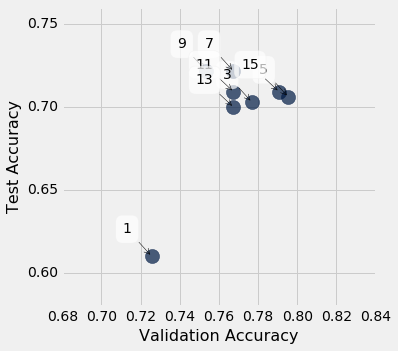

In [57]:
k_accuracies = Table(['k', 'Validation Accuracy', 'Test Accuracy'])
test_accuracy = accuracy_on(test_lyrics)
for k in range(1, 16, 2):
    k_accuracies.append([k, valid_accuracy(features_staff, k), test_accuracy(features_staff, k)])
k_accuracies.scatter(1, 2, labels=0, s=200)

**Question 4.1.6.** Does validation accuracy appear to be useful in selecting `k`, if what you care about most is classification accuracy on other unseen data (such as the test set)? Does the choice of `k` appear to matter at all? Explain your answer in 1 or 2 sentences.

Based on the scatter diagram above, the validation accuracy (with the exception of `k=1`), does not appear to be particularly useful in selecting `k` to determine accuracy on other unseen data. However, the choice of `k` *does* matter for reasons like (a) having an odd `k` to avoid ties between categories (*genres* in this case) and (b) it allows us to fine-tune which `k`s are best for validation and which `k`s are worth trying out on the test set.

Congratulations! You're done with the required portion of the project.

## 4.2. Extra Credit

Now that you know how to evaluate different feature sets, it's time to build the best classifier you can.

**Question 4.2.1.** Find a set of features that gives at least 85% accuracy on the validation set. 

In [ ]:
better_features = ...
print('Validation:', valid_accuracy(better_features, 5), 'Test:', test_accuracy(better_features, 5))

**Question 4.2.2.** Are these features any better on the test set than the staff features? If not, explain why that might be the case.

*Write your answer in text here.*

**Ungraded.** Feel free to create an even better classifier. You're not restricted to using only word proportions as features. For example, given the data, you could compute various notions of vocabulary size or estimated song length. If you think you built a classifier that works well, post on Piazza and let us know.

In [ ]:
#####################
# Custom Classifier #
#####################
